Importing all the libraries required

In [12]:
import pandas as pd
import random
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

Customer segemnts based on purchase behaviour

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` e

             movie_name                          movie_reviews  \
0      Terrible Mystery  The worst movie I have seen in years.   
1        Dull Adventure  The worst movie I have seen in years.   
2      Terrible Mystery  Fantastic storyline and great acting.   
3   Wonderful Adventure  Fantastic storyline and great acting.   
4  Incredible Chronicle  Fantastic storyline and great acting.   

   total_number_of_tickets_purchased  total_purchase_amount  \
0                                589                 787.35   
1                                472               15701.16   
2                                726               13724.86   
3                                821               19638.28   
4                                814                1038.56   

   purchase_frequency  
0                  20  
1                  43  
2                  22  
3                  23  
4                  36  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


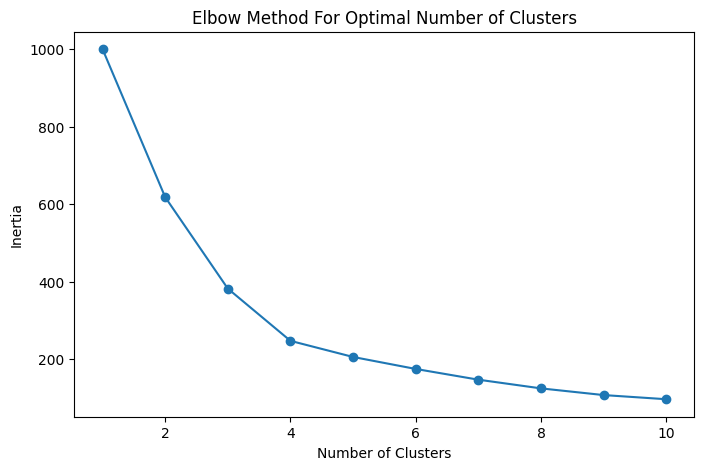

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


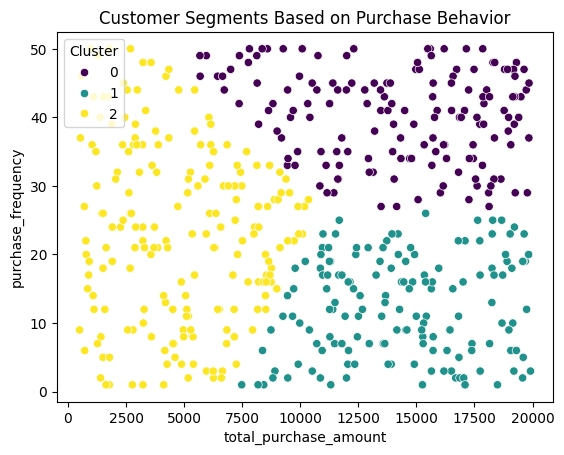

Cluster Centers:
[[1.41665491e+04 4.01806452e+01]
 [1.44019233e+04 1.23421053e+01]
 [4.86975093e+03 2.30829016e+01]]


In [15]:
# Download stopwords
nltk.download('stopwords')

# Load the generated dataset
df = pd.read_csv('movie_purchase_data.csv')

# Display the first few rows of the dataset
print(df.head())

# Select relevant features for clustering (e.g., 'total_purchase_amount', 'purchase_frequency')
features = df[['total_purchase_amount', 'purchase_frequency']]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

# Choose the optimal number of clusters (e.g., 3) based on the elbow curve
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Analyze the clusters
sns.scatterplot(x='total_purchase_amount', y='purchase_frequency', hue='Cluster', data=df, palette='viridis')
plt.title('Customer Segments Based on Purchase Behavior')
plt.show()

# Display the cluster centers
print("Cluster Centers:")
print(scaler.inverse_transform(kmeans.cluster_centers_))


Prediction of sentiment of a random review using Logistic Regression

In [18]:
# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove whitespace
    tokens = text.split()  # Split text into words
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing to the 'movie_reviews' column
df['Processed_Reviews'] = df['movie_reviews'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# Fit and transform the processed reviews
X = tfidf.fit_transform(df['Processed_Reviews']).toarray()

# For demonstration, we'll create a simple binary label for sentiment
# 1 for positive, 0 for negative reviews based on the presence of some keywords
positive_keywords = ['amazing', 'wonderful', 'fantastic', 'exciting', 'incredible']
df['Sentiment'] = df['Processed_Reviews'].apply(lambda x: 1 if any(word in x for word in positive_keywords) else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment'], test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predict the sentiments on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Function to predict sentiment for a new movie review
def predict_sentiment(review):
    processed_review = preprocess_text(review)
    vectorized_review = tfidf.transform([processed_review]).toarray()
    predicted_sentiment = model.predict(vectorized_review)
    return 'Positive' if predicted_sentiment[0] == 1 else 'Negative'

# Example prediction
new_review = "An incredible journey full of surprises."
print("Review:",new_review)
predicted_sentiment = predict_sentiment(new_review)
print(f'The predicted sentiment for the review is: {predicted_sentiment}')


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        43

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Review: An incredible journey full of surprises.
The predicted sentiment for the review is: Positive


Customer Segments Based on purchase behaviour and sentiment

             movie_name                          movie_reviews  \
0      Terrible Mystery  The worst movie I have seen in years.   
1        Dull Adventure  The worst movie I have seen in years.   
2      Terrible Mystery  Fantastic storyline and great acting.   
3   Wonderful Adventure  Fantastic storyline and great acting.   
4  Incredible Chronicle  Fantastic storyline and great acting.   

   total_number_of_tickets_purchased  total_purchase_amount  \
0                                589                 787.35   
1                                472               15701.16   
2                                726               13724.86   
3                                821               19638.28   
4                                814                1038.56   

   purchase_frequency  Cluster                 Processed_Reviews  Sentiment  
0                  20        4            worst movie seen years          0  
1                  43        5            worst movie seen years    

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

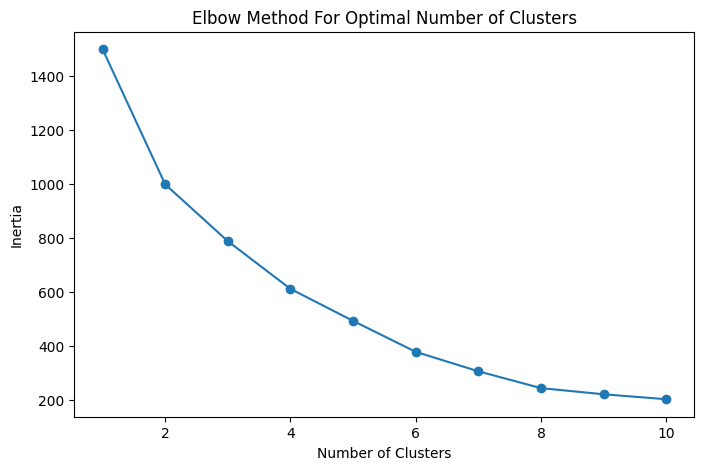

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


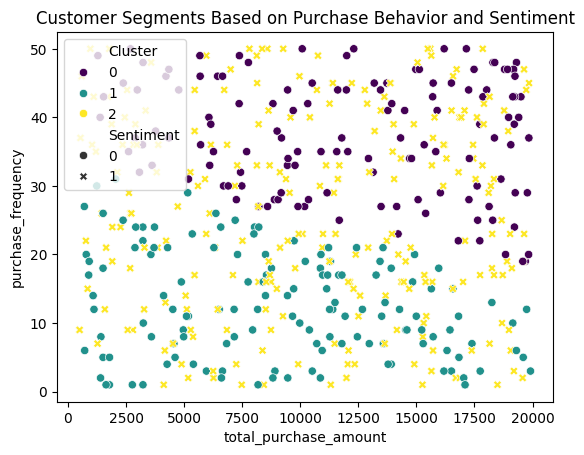

Cluster Centers:
[[1.21032612e+04 3.72692308e+01 5.55111512e-16]
 [9.20466014e+03 1.25539568e+01 4.99600361e-16]
 [1.07008557e+04 2.58398268e+01 1.00000000e+00]]


In [17]:

# Display the first few rows of the dataset
print(df.head())

# Helper function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove whitespace
    tokens = text.split()  # Split text into words
    tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Preprocess the 'movie_reviews' column
df['Processed_Reviews'] = df['movie_reviews'].apply(preprocess_text)

# Define positive and negative words
positive_words = ['amazing', 'wonderful', 'fantastic', 'exciting', 'incredible', 'great', 'loved', 'must-watch', 'thrilling']
negative_words = ['boring', 'terrible', 'dull', 'worst', 'bad', 'disappointing', 'waste', 'lifeless', 'nonsense']

# Helper function to determine sentiment
def determine_sentiment(review):
    positive_count = sum(word in review for word in positive_words)
    negative_count = sum(word in review for word in negative_words)
    return 'positive' if positive_count > negative_count else 'negative'

# Apply the sentiment function
df['Sentiment'] = df['Processed_Reviews'].apply(determine_sentiment)

# Convert 'Sentiment' to numerical values
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'negative': 0})

# Features for clustering
features = df[['total_purchase_amount', 'purchase_frequency', 'Sentiment']]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

# Choose the optimal number of clusters based on the elbow curve (e.g., 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Analysis of the clusters
sns.scatterplot(x='total_purchase_amount', y='purchase_frequency', hue='Cluster', style='Sentiment', data=df, palette='viridis')
plt.title('Customer Segments Based on Purchase Behavior and Sentiment')
plt.show()

# Display the cluster centers
print("Cluster Centers:")
print(scaler.inverse_transform(kmeans.cluster_centers_))
